In [17]:
import cv2
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

# pyton 3.9.11 / cuda / windows
# pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121 
# ipython kernel install --name "cuda-train" --user
# pip install ipython matplotlib
# print("Cuda available: ", torch.cuda.is_available())
# print("Device name:", torch.cuda.get_device_name())

In [18]:
#loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
train_label_data_path  = '/Users/finnschurmann/AI_Gruppenprojekt/gtFine_trainvaltest/gtFine/train'

train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))

valid_label_data_path  = '/Users/finnschurmann/AI_Gruppenprojekt/gtFine_trainvaltest/gtFine/val'  
valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))

train_img_path  = '/Users/finnschurmann/AI_Gruppenprojekt/leftImg8bit_trainvaltest/leftImg8bit/train'
train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))

valid_img_path  = '/Users/finnschurmann/AI_Gruppenprojekt/leftImg8bit_trainvaltest/leftImg8bit/val'
valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png"))


In [19]:
from collections import namedtuple
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

number of labels used = 19


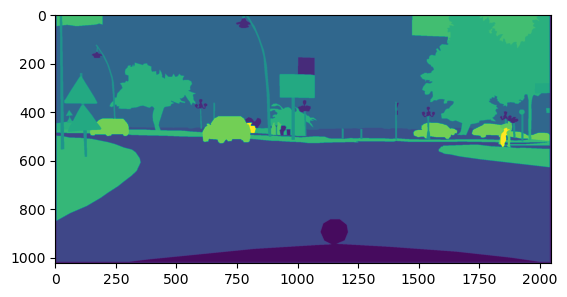

In [20]:
# labels that will be used has ignoreinEval == False
labels_used = []
ids = []
for i in range(len(labels)):
    if(labels[i].ignoreInEval == False):
      labels_used.append(labels[i])
      ids.append(labels[i].id)
print("number of labels used = " + format(len(labels_used )))
  
label_in = cv2.imread(train_labels[0])[:,:,0]#visualize a sample label
plt.imshow(label_in)
plt.show()
 
# create a dictionary with label_id as key & train_id as value
label_dic = {}
for i in range(len(labels)-1):
  label_dic[labels[i].id] = labels[i].trainId


In [21]:
#function to convert labelids to trainids
def createtrainID(label_in ,label_dic):
  mask = np.zeros((label_in.shape[0],label_in.shape[1]))
  l_un = np.unique(label_in)
  for i in range(len(l_un)):
    mask[label_in==l_un[i]] = label_dic[l_un[i]] 
  return mask

In [22]:
#function to visualize the labels
def visual_label(mask,labels_used, plot = False):
  
  # Create an empty 3D array for the label image
  label_img = np.zeros((mask.shape[0],mask.shape[1],3))

  # Create separate arrays for red, green, and blue channels
  r = np.zeros((mask.shape[0],mask.shape[1]))
  g = np.zeros((mask.shape[0],mask.shape[1]))
  b = np.zeros((mask.shape[0],mask.shape[1]))

  # Set the pixels to their corresponding RGB values
  l_un = np.unique(mask)

  # Iterate over unique values in the mask
  for i in range(len(l_un)):
    # Check if the label is less than 19
    if l_un[i]<19:
      # Assign RGB color values from labels_used to corresponding pixels
      r[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[0]
      g[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[1]
      b[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[2]
  
  # Assign RGB values to the label_img array
  label_img[:,:,0] = r/255
  label_img[:,:,1] = g/255
  label_img[:,:,2] = b/255

  # If plot=True, display the label image using matplotlib
  if plot:
    plt.imshow(label_img)
  
  # Return the resulting label image
  return label_img

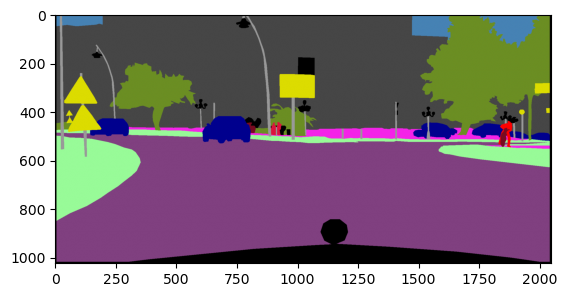

In [23]:
# display the labels in the example image 
label_img = visual_label(createtrainID(label_in, label_dic), labels_used,plot = True)

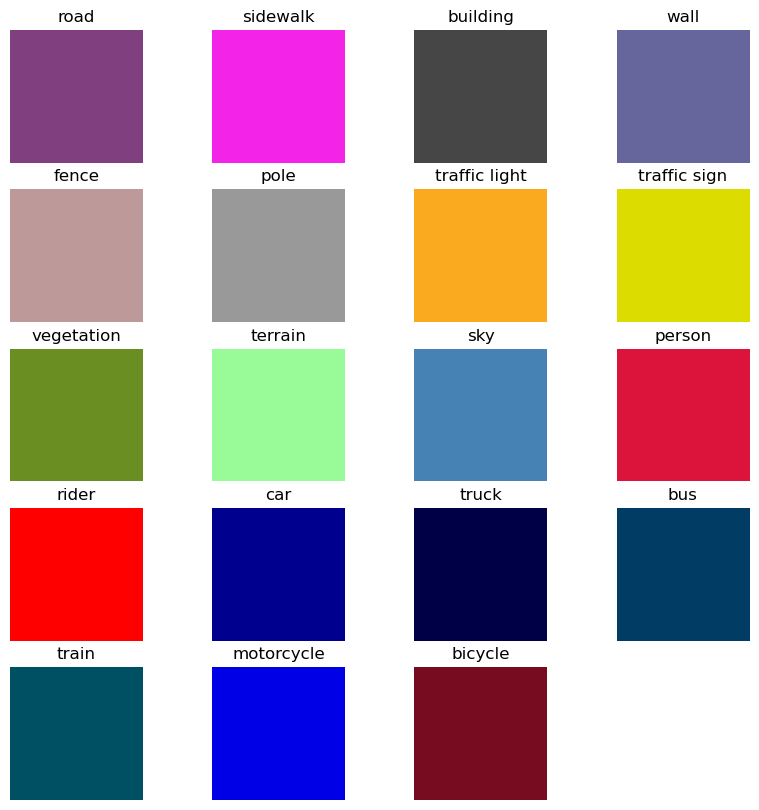

In [24]:
#description of different colors of labels
fig = plt.figure(figsize = (10,10))

for i in range(len(labels_used)):
    temp = np.zeros((5,5,3))
    temp[:,:,0] = labels_used[i].color[0]/255
    temp[:,:,1] = labels_used[i].color[1]/255
    temp[:,:,2] = labels_used[i].color[2]/255
    ax = fig.add_subplot(5, 4, i+1)
    ax.imshow(temp)
    ax.set_title(labels_used[i].name)
    ax.axis('off')

In [25]:
#function to generate images for training, validation and testing
def gen_images(x,s1=96,s2=96):

  # Get the number of channels (s3) from the shape of the first image
  _,_,s3 = cv2.imread(x[0]).shape
  
  # Initialize an empty 4D array to store the resized images
  img = np.zeros((len(x),s1,s2,s3))

  # Itereate over all images and resize them
  for i in range(len(x)):
      image= cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)
      image = image/255
      img[i,:,:,:] = image
    
  # Convert the img array to a PyTorch tensor and permute dimensions
  return torch.tensor(img).permute(0,3,1,2)



In [26]:
#function to generate images for training, validation and testing
def gen_mask_train(x,label_dic,s1=96,s2=96):

  # Initialize an empty 3D array to store the masks
  mask = np.zeros((len(x),s1,s2))

  # Iterate over the input images
  for i in range(len(x)):
      
      # Resize the image and create the mask using createtrainID function
      image = createtrainID(cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)[:,:,0],label_dic)

      # Assign the generated mask to the mask array
      mask[i,:,:] = image

      # Replace any values of 255 in the mask with 19
      mask[mask==255] = 19

    # Convert the mask array to a PyTorch tensor
  return torch.tensor(mask)

In [27]:
def split_dataset (train_inp, train_labels, valid_inp, valid_labels):

  '''Function spilts the dataset into train, validation and test datasets'''

  train = []
  for x in zip(train_inp,train_labels):
    train.append(x)
  valid_dataset =[]
  for x in zip(valid_inp,valid_labels):
    valid_dataset.append(x)

  n =  len(train)
  train_n = int(0.8*n) 
  np.random.seed(0)
  perm = np.random.permutation(n)
  train_dataset = []
  test_dataset = []
  for i in range(len(perm[0:train_n])):   
    train_dataset.append(train[perm[i]])
  for i in range(len(perm[train_n:n])):
    test_dataset.append(train[perm[i]]) 
  
  return train_dataset, valid_dataset, test_dataset

train_dataset, valid_dataset, test_dataset = split_dataset (train_inp, train_labels, valid_inp, valid_labels)

In [28]:
# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,          # Training dataset
    batch_size=200,          # Number of samples in each batch
    shuffle=True,            # Shuffle the data at the beginning of each epoch
    num_workers=0            # Number of subprocesses for data loading (0 for no parallelization)
)

# Create a DataLoader for the validation dataset
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,          # Validation dataset
    batch_size=200,          # Number of samples in each batch
    shuffle=True,            # Shuffle the data at the beginning of each epoch
    num_workers=0            # Number of subprocesses for data loading (0 for no parallelization)
)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset,           # Test dataset
    batch_size=200,          # Number of samples in each batch
    shuffle=True,            # Shuffle the data at the beginning of each epoch
    num_workers=0            # Number of subprocesses for data loading (0 for no parallelization)
)


In [29]:
print ("Training set size: {}".format(len(train_dataset)))
print ("Validation set size: {}".format(len(valid_dataset)))
print ("Test set size: {}".format(len(test_dataset)))

Training set size: 2380
Validation set size: 500
Test set size: 595


In [30]:
# Check if a CUDA-capable GPU is available
# If available, use 'cuda' (GPU), otherwise use 'cpu' (CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the selected device
print(device)


cpu


In [31]:
# Create an iterator from the training data loader
data_iter = iter(train_loader)

# Get the next batch of data
x, y = next(data_iter)

# Generate images from the input data
img = gen_images(x)

# Move the images to the specified device (either 'cuda' or 'cpu') and convert to float
img = img.to(device).type(torch.float)

# Generate training masks from the target data using label_dic
mask = gen_mask_train(y, label_dic)

# Move the masks to the specified device (either 'cuda' or 'cpu')
mask = mask.to(device)


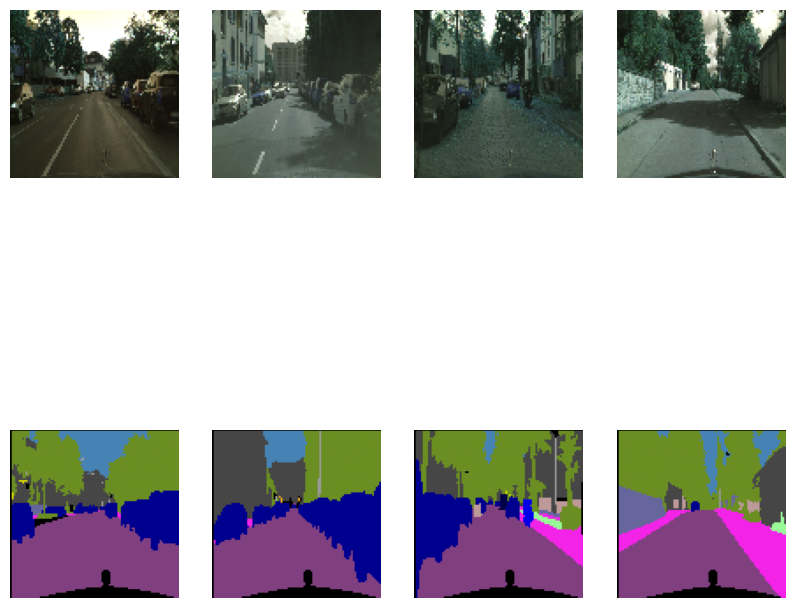

In [32]:
# Number of images to visualize
n_images = 4

# Create a figure with a specified size
fig = plt.figure(figsize=(10, 10))

# Loop to visualize images and labels
for i in range(n_images * 2):
    # Add a subplot to the figure
    ax = fig.add_subplot(2, n_images, i + 1)

    # Check if the current iteration is for an input image or a label
    if i < n_images:
        # Visualize input images
        ax.imshow(img.permute(0, 2, 3, 1)[i, :, :, :].cpu().numpy())
    else:
        # Visualize labels using the visual_label function
        ax.imshow(visual_label(mask[int(i % n_images), :, :].cpu().numpy(), labels_used))

    # Turn off axis labels
    ax.axis('off')

# Show the figure with visualized images and labels
plt.show()


# Model Development (SegNet)

In [33]:
#create different operations of the network opearations of the network
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

In [34]:
# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2) # skip connection <-------------------------
        x4 = self.conv3(x3)#                                                |
        x5 = self.conv4(x4)#                                                |
        x6,idx2 = self.down2(x5)# skip connection <-------------------      |
        x7 = self.conv5(x6)#                                         |      |
        x8 = self.conv6(x7)#                                         |      |
        x9 = self.conv7(x8)#                                         |      |
        x10,idx3 = self.down3(x9)# skip connection <-----------      |      |
        x11 = self.conv8(x10)#                                |      |      |
        x12 = self.conv9(x11)#                                |      |      | 
        x13 = self.conv10(x12)#                               |      |      |
        x14,idx4 = self.down4(x13)# skip connection <---      |      |      |
        x15 = self.conv11(x14)#                        |      |      |      |
        x16 = self.conv12(x15)#                        |      |      |      |
        x17 = self.conv13(x16)#                        |      |      |      |
        x18,idx5 = self.down5(x17)#                    |      |      |      |
        x19 = self.up1(x18,idx5,x17)#                  |      |      |      |
        x20 = self.conv14(x19)#                        |      |      |      |
        x21 = self.conv15(x20)#                        |      |      |      |
        x22 = self.conv16(x21)#                        |      |      |      |
        x23 = self.up2(x22,idx4,x13)# skip connection <-      |      |      |
        x24 = self.conv17(x23)#                               |      |      |
        x25 = self.conv18(x24)#                               |      |      |
        x26 = self.conv19(x25)#                               |      |      |
        x27 = self.up3(x26,idx3,x9)# skip connection <---------      |      |
        x28 = self.conv20(x27)#                                      |      |
        x29 = self.conv21(x28)#                                      |      |
        x30 = self.conv22(x29)#                                      |      |
        x31 = self.up4(x30,idx2,x5)# skip connection <----------------      |                                
        x32 = self.conv23(x31)#                                             |
        x33 = self.conv24(x32)#                                             |
        x34 = self.up4(x33,idx1,x2)# skip connection <-----------------------
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    

In [35]:
net = SegNet(3,20) #one additional class for pixel ignored

In [36]:
# Define a function to count trainable parameters in a model
def count_parameters(model):
    # Sum the number of elements in trainable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters for the model 'net'
print(count_parameters(net))


29454548


In [37]:
NUM_EPOCH = 2 # e.g. 40
BATCH_SIZE = 128 # e.g. 8
LR = 0.001 # e.g. 0.001

In [38]:
# Define the loss function
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=LR,
)

In [39]:
# Define a function to initialize parameters in a PyTorch module
def initialize_parameters(m):
    # Check if the module is an instance of nn.Conv2d
    if isinstance(m, nn.Conv2d):
        # Initialize the weights using Kaiming normal initialization with ReLU nonlinearity
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        
        # Initialize biases to zero
        nn.init.constant_(m.bias.data, 0)

In [40]:
# Apply the initialize_parameters function to all modules in the neural network 'net'
net.apply(initialize_parameters)


SegNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): single_conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down2): dow

In [41]:
# Initialize an array to store class weights
weights = np.zeros((20))

# Iterate through the training data loader
for (_, y) in tqdm(train_loader):
    # Generate training masks using gen_mask_train function
    y = gen_mask_train(y, label_dic)
    
    # Move the generated masks to the specified device and convert to long data type
    y = y.to(device).long()
    
    # Iterate through each class
    for i in range(20):
        # Accumulate the pixel counts for each class
        weights[i] += torch.sum((y == i).type(torch.uint8))

100%|██████████| 12/12 [00:25<00:00,  2.09s/it]


In [42]:
# Normalize the class weights
weights = np.max(weights) / weights

# Convert the normalized weights to a PyTorch FloatTensor
weights = torch.FloatTensor(weights)


In [43]:
"""using cross entropy loss, but the semantic segmentation suffers from class imbalance so we will use weights for each class in the last update 
for our project"""
net = net.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Training SegNet on cityscapes dataset

In [44]:
def mean_iou(y_pred, y, num_classes=20, last_background=True, smooth=0.001):
    # Convert predicted labels to class indices by taking the argmax along the channel dimension
    y_pred = torch.argmax(y_pred, dim=1)

    # Initialize a list to store IoU for each class
    mean_IoU = []

    # Adjust the number of classes if last_background is True
    if last_background:
        num_classes = num_classes - 1

    # Iterate over each class
    for i in range(num_classes):
        # Create binary masks for predicted and true labels for the current class
        class_pred = (y_pred == i).type(torch.uint8)
        class_truth = (y == i).type(torch.uint8)

        # Calculate union and intersection of the binary masks
        union = torch.logical_or(class_pred, class_truth).type(torch.uint8)
        intersection = torch.logical_and(class_pred, class_truth).type(torch.uint8)

        # Calculate IoU for each example in the batch
        IoU = torch.sum(intersection + smooth, dim=(1, 2)) / torch.sum(union + smooth, dim=(1, 2))

        # Append the mean IoU for the current class to the list
        mean_IoU.append(IoU.mean())

    # Calculate the overall mean IoU
    mean_IoU = sum(mean_IoU) / num_classes

    return mean_IoU


In [45]:
# Define the training function
def train(model, iterator, optimizer, criterion, device, label_dic):
    # Initialize epoch loss and IoU
    epoch_loss = 0
    epoch_IoU = 0
    
    # Set the model to training mode
    model.train()
    
    # Iterate through the training data loader
    for (x, y) in tqdm(iterator):
        # Generate images and move to the specified device
        x = gen_images(x)
        x = x.to(device).type(torch.float)
        
        # Generate training masks and move to the specified device
        y = gen_mask_train(y, label_dic)
        y = y.to(device).long()
        
        # Zero the gradients
        optimizer.zero_grad()
                
        # Forward pass
        y_pred = model(x)
        
        # Calculate the loss
        loss = criterion(y_pred, y)
        
        # Calculate the mean IoU
        IoU = mean_iou(y_pred, y)
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Accumulate the epoch loss and IoU
        epoch_loss += loss.item()
        epoch_IoU += IoU.item()
        
    # Calculate and return the average loss and IoU for the epoch
    return epoch_loss / len(iterator), epoch_IoU / len(iterator)


In [46]:
# Define the evaluation function
def evaluation(model, iterator, criterion, device, label_dic):
    # Initialize epoch loss and IoU
    epoch_loss = 0
    epoch_IoU = 0
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate through the evaluation data loader
        for (x, y) in tqdm(iterator):
            # Generate images and move to the specified device
            x = gen_images(x)
            x = x.to(device).type(torch.float)
            
            # Generate training masks and move to the specified device
            y = gen_mask_train(y, label_dic)
            y = y.to(device).long()
            
            # Forward pass
            y_pred = model(x)
            
            # Calculate the loss
            loss = criterion(y_pred, y)
            
            # Calculate the mean IoU
            IoU = mean_iou(y_pred, y)
            
            # Accumulate the epoch loss and IoU
            epoch_loss += loss.item()
            epoch_IoU += IoU.item()
        
    # Calculate and return the average loss and IoU for the epoch
    return epoch_loss / len(iterator), epoch_IoU / len(iterator)


In [47]:
import time

# Define a function to calculate epoch time
def epoch_time(start_time, end_time):
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    
    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs


In [48]:
# Train the model on the training data loader
train_loss, train_iou = train(net, train_loader, optimizer, criterion, device, label_dic)

# Evaluate the model on the validation data loader
valid_loss, valid_iou = evaluation(net, valid_loader, criterion, device, label_dic)


100%|██████████| 3/3 [00:39<00:00, 13.22s/it]


In [49]:
import torch
import time

# Initialize the best validation loss to positive infinity
best_valid_loss = float('inf')

# Initialize early stopping parameters
early_stop_counter = 0
early_stop_patience = 5  # You can adjust this based on your preference

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop through epochs
for epoch in range(99):
    # Record the start time of the epoch
    start_time = time.time()
    
    # Train the model on the training data loader
    train_loss, train_iou = train(net, train_loader, optimizer, criterion, device, label_dic)
    
    # Evaluate the model on the validation data loader
    valid_loss, valid_iou = evaluation(net, valid_loader, criterion, device, label_dic)
    
    # Record the end time of the epoch
    end_time = time.time()
    
    # Calculate and print the elapsed time for the epoch
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save the model if the current validation loss is the best so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), f'net_epoch{epoch}.pth')
        # Reset early stopping counter if the model improves
        early_stop_counter = 0
    else:
        # Increment early stopping counter if there is no improvement
        early_stop_counter += 1

    # Print epoch information
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train IoU: {train_iou}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Valid IoU: {valid_iou}')

    # Check for early stopping
    if early_stop_counter >= early_stop_patience:
        print(f'Early stopping triggered. No improvement in validation loss for {early_stop_patience} epochs.')
        break

100%|██████████| 3/3 [00:39<00:00, 13.06s/it]


Epoch: 01 | Epoch Time: 9m 3s
	Train Loss: 1.508 | Train IoU: 0.5416993449131647
	Val. Loss: 2.055 | Valid IoU: 0.5166046023368835


100%|██████████| 3/3 [00:39<00:00, 13.23s/it]


Epoch: 02 | Epoch Time: 8m 48s
	Train Loss: 1.205 | Train IoU: 0.572673961520195
	Val. Loss: 1.567 | Valid IoU: 0.5393905639648438


100%|██████████| 3/3 [00:39<00:00, 13.14s/it]


Epoch: 03 | Epoch Time: 8m 58s
	Train Loss: 1.107 | Train IoU: 0.5879347175359726
	Val. Loss: 1.132 | Valid IoU: 0.5675652821858724


100%|██████████| 3/3 [00:39<00:00, 13.27s/it]


Epoch: 04 | Epoch Time: 8m 51s
	Train Loss: 1.036 | Train IoU: 0.5978126227855682
	Val. Loss: 1.142 | Valid IoU: 0.5568583806355795


100%|██████████| 3/3 [00:38<00:00, 12.99s/it]


Epoch: 05 | Epoch Time: 8m 47s
	Train Loss: 0.985 | Train IoU: 0.6066282838582993
	Val. Loss: 0.992 | Valid IoU: 0.5858576695124308


100%|██████████| 3/3 [00:38<00:00, 13.00s/it]


Epoch: 06 | Epoch Time: 8m 55s
	Train Loss: 0.924 | Train IoU: 0.6163672357797623
	Val. Loss: 0.934 | Valid IoU: 0.5923720796902975


100%|██████████| 3/3 [00:39<00:00, 13.23s/it]


Epoch: 07 | Epoch Time: 8m 46s
	Train Loss: 0.874 | Train IoU: 0.6263985832532247
	Val. Loss: 1.013 | Valid IoU: 0.582158625125885


100%|██████████| 3/3 [00:38<00:00, 12.98s/it]


Epoch: 08 | Epoch Time: 8m 44s
	Train Loss: 0.845 | Train IoU: 0.6310984839995702
	Val. Loss: 0.963 | Valid IoU: 0.5958044528961182


100%|██████████| 3/3 [00:39<00:00, 13.13s/it]


Epoch: 09 | Epoch Time: 8m 53s
	Train Loss: 0.826 | Train IoU: 0.6315306772788366
	Val. Loss: 1.039 | Valid IoU: 0.5606083075205485


100%|██████████| 3/3 [00:38<00:00, 12.94s/it]


Epoch: 10 | Epoch Time: 8m 49s
	Train Loss: 0.804 | Train IoU: 0.6304699331521988
	Val. Loss: 0.891 | Valid IoU: 0.5955884059270223


100%|██████████| 3/3 [00:39<00:00, 13.14s/it]


Epoch: 11 | Epoch Time: 8m 48s
	Train Loss: 0.782 | Train IoU: 0.6332730948925018
	Val. Loss: 0.913 | Valid IoU: 0.5897091825803121


100%|██████████| 3/3 [00:39<00:00, 13.08s/it]


Epoch: 12 | Epoch Time: 8m 47s
	Train Loss: 0.761 | Train IoU: 0.637717475493749
	Val. Loss: 0.917 | Valid IoU: 0.6011759042739868


100%|██████████| 3/3 [00:39<00:00, 13.06s/it]


Epoch: 13 | Epoch Time: 8m 41s
	Train Loss: 0.738 | Train IoU: 0.6411673724651337
	Val. Loss: 0.850 | Valid IoU: 0.606937845547994


100%|██████████| 3/3 [00:39<00:00, 13.04s/it]


Epoch: 14 | Epoch Time: 8m 55s
	Train Loss: 0.724 | Train IoU: 0.6439602772394816
	Val. Loss: 0.855 | Valid IoU: 0.6091536283493042


100%|██████████| 3/3 [00:39<00:00, 13.06s/it]


Epoch: 15 | Epoch Time: 8m 49s
	Train Loss: 0.715 | Train IoU: 0.6424597452084223
	Val. Loss: 0.817 | Valid IoU: 0.6166285872459412


100%|██████████| 3/3 [00:39<00:00, 13.21s/it]


Epoch: 16 | Epoch Time: 8m 50s
	Train Loss: 0.702 | Train IoU: 0.6449907869100571
	Val. Loss: 0.767 | Valid IoU: 0.6097036401430765


100%|██████████| 3/3 [00:40<00:00, 13.38s/it]


Epoch: 17 | Epoch Time: 8m 54s
	Train Loss: 0.698 | Train IoU: 0.6406174997488657
	Val. Loss: 0.829 | Valid IoU: 0.6076929966608683


100%|██████████| 3/3 [00:39<00:00, 13.19s/it]


Epoch: 18 | Epoch Time: 8m 51s
	Train Loss: 0.692 | Train IoU: 0.6422233780225118
	Val. Loss: 0.774 | Valid IoU: 0.6039625406265259


100%|██████████| 3/3 [00:39<00:00, 13.04s/it]


Epoch: 19 | Epoch Time: 8m 48s
	Train Loss: 0.673 | Train IoU: 0.6450696488221487
	Val. Loss: 0.773 | Valid IoU: 0.6101883252461752


100%|██████████| 3/3 [00:39<00:00, 13.12s/it]


Epoch: 20 | Epoch Time: 8m 52s
	Train Loss: 0.663 | Train IoU: 0.6427478988965353
	Val. Loss: 0.793 | Valid IoU: 0.6108607848485311


100%|██████████| 3/3 [00:39<00:00, 13.04s/it]


Epoch: 21 | Epoch Time: 8m 49s
	Train Loss: 0.648 | Train IoU: 0.6432653019825617
	Val. Loss: 0.740 | Valid IoU: 0.6183467706044515


100%|██████████| 3/3 [00:39<00:00, 13.12s/it]


Epoch: 22 | Epoch Time: 8m 52s
	Train Loss: 0.645 | Train IoU: 0.6447568386793137
	Val. Loss: 0.758 | Valid IoU: 0.6060744325319926


100%|██████████| 3/3 [00:39<00:00, 13.13s/it]


Epoch: 23 | Epoch Time: 8m 56s
	Train Loss: 0.646 | Train IoU: 0.6408344209194183
	Val. Loss: 0.820 | Valid IoU: 0.5988655090332031


100%|██████████| 3/3 [00:39<00:00, 13.23s/it]


Epoch: 24 | Epoch Time: 8m 48s
	Train Loss: 0.636 | Train IoU: 0.6446543186903
	Val. Loss: 0.810 | Valid IoU: 0.6006703575452169


100%|██████████| 3/3 [00:39<00:00, 13.16s/it]


Epoch: 25 | Epoch Time: 8m 56s
	Train Loss: 0.621 | Train IoU: 0.6464186857144038
	Val. Loss: 0.789 | Valid IoU: 0.606977641582489


100%|██████████| 3/3 [00:40<00:00, 13.35s/it]

Epoch: 26 | Epoch Time: 8m 53s
	Train Loss: 0.623 | Train IoU: 0.6441377053658167
	Val. Loss: 0.791 | Valid IoU: 0.5899442235628763
Early stopping triggered. No improvement in validation loss for 5 epochs.


# Visualize the results on test dataset


In [54]:
#load the best model
net.load_state_dict(torch.load('net_epoch20.pth'))

<All keys matched successfully>

In [55]:
# Evaluate the trained model on the test data loader
test_loss, test_iou = evaluation(net, test_loader, criterion, device, label_dic)

# Print the test loss and IoU
print(f'\tTest Loss: {test_loss:.3f} | Test IoU: {test_iou}')

100%|██████████| 3/3 [00:47<00:00, 15.98s/it]

	Test Loss: 0.630 | Test IoU: 0.6502145926157633


In [56]:
# print some sample test output and ground
data_iter = iter(test_loader)
x,y = next(data_iter)
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

net.eval()
with torch.no_grad():
  y_pred = net(img)

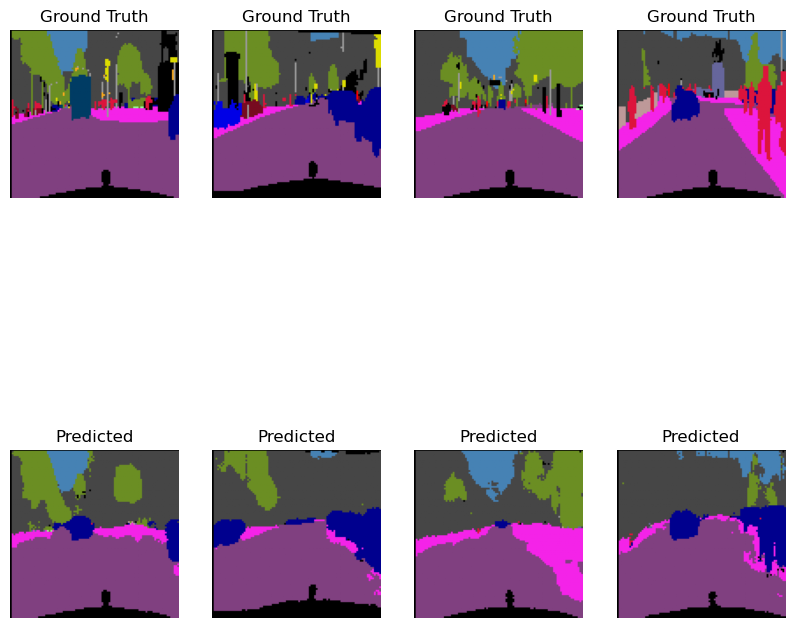

In [57]:
# Create a figure with a specified size
fig = plt.figure(figsize=(10, 10))

# Iterate over a range of indices (11 to 14)
for i in range(11, 15):
    # Plot the Ground Truth Mask
    ax = fig.add_subplot(2, 4, i - 10)
    ground_truth_visualization = visual_label(mask[i, :, :].cpu().numpy(), labels_used)
    ax.imshow(ground_truth_visualization)
    ax.set_title('Ground Truth')
    ax.axis('off')

    # Plot the Predicted Mask
    ax = fig.add_subplot(2, 4, i - 6)
    y_test = y_pred.permute(0, 2, 3, 1)[i, :, :, :].cpu().numpy()
    predicted_visualization = visual_label(np.argmax(y_test, axis=2), labels_used)
    ax.imshow(predicted_visualization)
    ax.set_title('Predicted')
    ax.axis('off')

# Display the figure
plt.show()
